#TODO: Match notation to paper, write a bit of text (in line with the paper)

Illustrate the basic idea behind the free energy objective for bounded-rational decision-making.

### Free energy optimization

Random variable $x$, a utility function $U(x)$, inverse temperature $\beta$ and a prior distribution $p_0(x)$. $U(x)$ denotes gains in utility, that is $U(x):=\tilde U(p(x))- \tilde U(p_0(x))$.

The negative free energy difference is given as

$-\Delta F = \sum_x p(x)U(x)-\frac{1}{\beta}\underbrace{\sum_x  p(x)\log \frac{p(x)}{p_0(x)}}_{D_\mathrm{KL}(p(x)||p_0(x))}$


We try to find the posterior distribution $p^*(x)$ that maximizes the negative free energy difference:

$p^*(x)=\underset{p(x)}{\operatorname{arg max}}~\sum_x p(x)U(x)-\frac{1}{\beta}\sum_x  p(x) \log \frac{p(x)}{p_0(x)}$

The KL-term can be considered as an information effort that is translated into an information cost through the inverse temperature. This leads to the interpretation of the free energy functional in terms of bounded-rational decision making, where an agent tries to act in a way such that the expected utility is large while at the same time keeping information cost low.


### Solution to free energy optimization

The solution can be computed in closed-form

$p^*(x)=\frac{1}{Z}p_0(x)e^{\beta U(x)}$

with $Z=\sum_x p_0(x)e^{\beta U(x)}$

$p^*(x)$ can be computed with the function below.

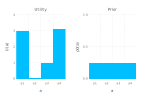

In [80]:
using BlahutArimoto, Gadfly

#create n discrete actions a
a = [1:4]
na = length(a)
a_strings = ["a$aval" for aval in a] #string representation for plotting


#--------- choose either one of the p0s (by commenting/uncommenting) ---------
#uniform p0(a)
p0 = ones(na)/na

#skewed p0(a)
#p0 = ones(na)
#p0[1]=2
#p0 = p0/sum(p0)
#---------------------


#U(a) - utility with two peaks that are almost identical in value
U = ones(na)
U[1]=3
U[2]=0.02
U[end]=3.1



#create (bar) plots for utility and prior
plt_u = plot(x=a_strings,y=U,Geom.bar, Scale.x_discrete, 
        Guide.xlabel("a"),Guide.ylabel("U(a)",orientation=:vertical),Guide.title("Utility"))

plt_p0 = plot(x=a_strings,y=p0,Geom.bar, Scale.x_discrete, Scale.y_continuous(minvalue=0, maxvalue=1), 
         Guide.xlabel("a"),Guide.ylabel("p0(a)",orientation=:vertical),Guide.title("Prior"))

#show both plots stacked horizontally
hstack(plt_u,plt_p0)

Drag the slider and see how the inverse temperature influences the posterior.

Slider{Float64}([Input{Float64}] 25.0,"inverse temp. β",25.0,0.0:0.1:50.0)

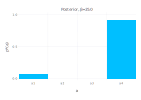

In [81]:
#compute the posterior p(a), using the inverse temperature β as a parameter
#create a slider to interactively change the inverse temperature
using Reactive, Interact

println("Drag the slider and see how the inverse temperature influences the posterior.")
sl_β = slider(0:0.1:50, label="inverse temp. β")    
display(sl_β) #displays the slider at the output of the current cell

#tie the slider with the plotting routine (this will also show the figure, since it's the last command in this cell)
plt_pa = lift(β->begin
                    pa = boltzmanndist(p0,β,U) #compute posterior
                    plt_pa = plot(x=a_strings,y=pa,Geom.bar, Scale.x_discrete, Scale.y_continuous(minvalue=0, maxvalue=1), 
                             Guide.xlabel("a"),Guide.ylabel("p*(a)",orientation=:vertical),Guide.title("Posterior, β=$β"))
               end,sl_β)

For the uniform prior:
For low $\beta$ (close to 1), the posterior is almost indifferent between $a1$ and $a4$, and at the same time has a very low chance of picking one of the "bad" options. This is a trade-off between using low computational resources (given the uniform prior) versus achieving a high expected utility. For large $\beta$, the agent (almost) deterministically picks $a4$ which will yield the highest expected utility, but also incurs large computational cost.

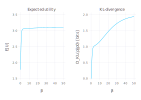

In [82]:
#Sweep through β values and compute expected utility and KL-divergence
using Distances

β_sweep = [0:0.1:50]
nβ = length(β_sweep)

EU = zeros(nβ)
DKL = zeros(nβ)

#inverse temp. sweep
for i=1:nβ
    #compute posterior
    pa_s = boltzmanndist(p0,β_sweep[i],U)
    #compute expected utility = ∑ p(a)U(a)
    EUvec = (pa_s') * U  #this will create a Float vector with only one element 
                         #(which is still different from a scalar in Julia)
    EU[i] = EUvec[1]  #this will actually extract the Float scalar
    DKL[i] = kl_divergence(pa_s,p0)/log(2) #divide by log(2) for bits
end

plt_EU = plot(x=β_sweep,y=EU,Geom.line,
              Guide.xlabel("β"),Guide.ylabel("E[U]",orientation=:vertical),Guide.title("Expected utility"))

plt_DKL = plot(x=β_sweep,y=DKL,Geom.line,
               Guide.xlabel("β"),Guide.ylabel("D_KL(p||p0) [bits]",orientation=:vertical),Guide.title("KL-divergence"))

hstack(plt_EU,plt_DKL)

If the performance goal is set for instance to achieving $\approx 96\%$ of the maximum utility on average (which translates to an expected utility of roughly $3$ compared to the maximum of $3.1$), then an agent which is able to process roughly $1$ bit suffices. If the performance goal is set to achieving $99.999\%$ of the maximum utility on average, then an agent with much larger computational capacity of almost $2$ bits is needed.

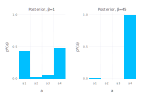

In [83]:
#for final figure: compute two different posteriors (low and high inverse temp.)

β_lo = 1  #inv. temp. for posterior with low computational resources (will stick close to prior)
β_hi = 45   #inv. temp. posterior with high computational resources (can deviate a lot from prior)

#compute posteriors
pa_lo = boltzmanndist(p0,β_lo,U)
pa_hi = boltzmanndist(p0,β_hi,U)


#create plots
plt_pa_lo = plot(x=a_strings,y=pa_lo,Geom.bar, Scale.x_discrete, Scale.y_continuous(minvalue=0, maxvalue=1), 
                 Guide.xlabel("a"),Guide.ylabel("p*(a)",orientation=:vertical),Guide.title("Posterior, β=$β_lo"))
plt_pa_hi = plot(x=a_strings,y=pa_hi,Geom.bar, Scale.x_discrete, Scale.y_continuous(minvalue=0, maxvalue=1), 
                 Guide.xlabel("a"),Guide.ylabel("p*(a)",orientation=:vertical),Guide.title("Posterior, β=$β_hi"))


hstack(plt_pa_lo, plt_pa_hi)

In [84]:
#compose final figure - stacking all the plots
plt_final = vstack(hstack(plt_u,plt_p0,plt_EU),hstack(plt_pa_lo, plt_pa_hi,plt_DKL))

#show figure
display(plt_final)

#store figure (make sure that the folder 'Figures' exists or change path)
w = 18cm
h = 12cm
draw(SVG("Figures/FEOptimization.svg", w, h), plt_final) #uncomment to store figure

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 β 
 
 
 -60 
 -50 
 -40 
 -30 
 -20 
 -10 
 0 
 10 
 20 
 30 
 40 
 50 
 60 
 70 
 80 
 90 
 100 
 110 
 -50 
 -48 
 -46 
 -44 
 -42 
 -40 
 -38 
 -36 
 -34 
 -32 
 -30 
 -28 
 -26 
 -24 
 -22 
 -20 
 -18 
 -16 
 -14 
 -12 
 -10 
 -8 
 -6 
 -4 
 -2 
 0 
 2 
 4 
 6 
 8 
 10 
 12 
 14 
 16 
 18 
 20 
 22 
 24 
 26 
 28 
 30 
 32 
 34 
 36 
 38 
 40 
 42 
 44 
 46 
 48 
 50 
 52 
 54 
 56 
 58 
 60 
 62 
 64 
 66 
 68 
 70 
 72 
 74 
 76 
 78 
 80 
 82 
 84 
 86 
 88 
 90 
 92 
 94 
 96 
 98 
 100 
 -50 
 0 
 50 
 100 
 -50 
 -45 
 -40 
 -35 
 -30 
 -25 
 -20 
 -15 
 -10 
 -5 
 0 
 5 
 10 
 15 
 20 
 25 
 30 
 35 
 40 
 45 
 50 
 55 
 60 
 65 
 70 
 75 
 80 
 85 
 90 
 95 
 100 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path fill="none" d="M114.91,79.48 L 114.95 79.39 114.99 79.13 115.03 78.73 115.07 78.24 115.11 77.68 115.15 77.09 115.19 76.51 115.22 75.95 115.26 75.43 115.3 74.96 115.34 74.53 115.38 74.16 115.42 73.83 115.46 73.55 115.5 73.3 115.54 73.1 115.58 72.92 115.61 72.76 115.65 72.64 115.69 72.53 115.73 72.43 115.77 72.35 115.81 72.29 115.85 72.23 115.89 72.18 115.93 72.13 115.97 72.1 116.01 72.07 116.04 72.04 116.08 72.01 116.12 71.99 116.16 71.97 116.2 71.95 116.24 71.93 116.28 71.92 116.32 71.9 116.36 71.89 116.4 71.87 116.43 71.86 116.47 71.85 116.51 71.83 116.55 71.82 116.59 71.81 116.63 71.8 116.67 71.78 116.71 71.77 116.75 71.76 116.79 71.75 116.82 71.73 116.86 71.72 116.9 71.71 116.94 71.69 116.98 71.68 117.02 71.67 117.06 71.65 117.1 71.64 117.14 71.63 117.18 71.61 117.21 71.6 117.25 71.58 117.29 71.57 117.33 71.55 117.37 71.54 117.41 71.52 117.45 71.51 117.49 71.49 117.53 71.47 117.57 71.46 117.6 71.44 117.64 71.43 117.68 71.41 117.72 71.39 117.76 71.37 117.8 71.36 117.84 71.34 117.88 71.32 117.92 71.3 117.96 71.29 117.99 71.27 118.03 71.25 118.07 71.23 118.11 71.21 118.15 71.19 118.19 71.18 118.23 71.16 118.27 71.14 118.31 71.12 118.35 71.1 118.39 71.08 118.42 71.06 118.46 71.04 118.5 71.02 118.54 71 118.58 70.98 118.62 70.96 118.66 70.94 118.7 70.92 118.74 70.9 118.78 70.88 118.81 70.85 118.85 70.83 118.89 70.81 118.93 70.79 118.97 70.77 119.01 70.75 119.05 70.73 119.09 70.7 119.13 70.68 119.17 70.66 119.2 70.64 119.24 70.62 119.28 70.59 119.32 70.57 119.36 70.55 119.4 70.53 119.44 70.5 119.48 70.48 119.52 70.46 119.56 70.44 119.59 70.41 119.63 70.39 119.67 70.37 119.71 70.34 119.75 70.32 119.79 70.3 119.83 70.27 119.87 70.25 119.91 70.23 119.95 70.2 119.98 70.18 120.02 70.16 120.06 70.13 120.1 70.11 120.14 70.09 120.18 70.06 120.22 70.04 120.26 70.02 120.3 69.99 120.34 69.97 120.38 69.94 120.41 69.92 120.45 69.9 120.49 69.87 120.53 69.85 120.57 69.83 120.61 69.8 120.65 69.78 120.69 69.75 120.73 69.73 120.77 69.71 120.8 69.68 120.84 69.66 120.88 69.63 120.92 69.61 120.96 69.59 121 69.56 121.04 69.54 121.08 69.51 121.12 69.49 121.16 69.47 121.19 69.44 121.23 69.42 121.27 69.39 121.31 69.37 121.35 69.35 121.39 69.32 121.43 69.3 121.47 69.27 121.51 69.25 121.55 69.23 121.58 69.2 121.62 69.18 121.66 69.15 121.7 69.13 121.74 69.11 121.78 69.08 121.82 69.06 121.86 69.04 121.9 69.01 121.94 68.99 121.97 68.97 122.01 68.94 122.05 68.92 122.09 68.9 122.13 68.87 122.17 68.85 122.21 68.83 122.25 68.8 122.29 68.78 122.33 68.76 122.36 68.73 122.4 68.71 122.44 68.69 122.48 68.66 122.52 68.64 122.56 68.62 122.6 68.6 122.64 68.57 122.68 68.55 122.72 68.53 122.76 68.51 122.79 68.48 122.83 68.46 122.87 68.44 122.91 68.42 122.95 68.39 122.99 68.37 123.03 68.35 123.07 68.33 123.11 68.31 123.15 68.28 123.18 68.26 123.22 68.24 123.2